In [1]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx 
%matplotlib inline
import pickle
import powerlaw
import pandas as pd
import operator
import collections

# Table of Contents

### [Section 1](#section1): Depedency Graph - Read in Data and Build Data Structures 
### [Section 2](#section2): Statistical Analysis of Dependency Data
### [Section 3](#section3): Create Graph and Run Dependency Network Statistics 
### [Section 4](#section4): Dependency Network Statistics Output 

<a id = "section1"></a>
## Section 1: Dependency Graph - Read in Data and Build Data Structure

In [2]:
#Load Python Package Information
with open('./data/updated_pypi.json') as json_file:
    data = json.load(json_file)

In [3]:
#See Length of data
len(data)

216382

In [4]:
#Example Data Point
data[3487]

{'git_name': '',
 'github': 'http://ajenti.org',
 'description': 'A File Manager plugin for Ajenti panel',
 'author': 'Ajenti project',
 'lib_name': 'ajenti.plugin.filemanager',
 'reqs': None,
 'author_name': 'Ajenti project',
 'name': 'ajenti.plugin.filemanager'}

In [5]:
#Helper Function to get each packages list of requirements
def get_req(pack_name, req):
    '''
    pack_name: string of package name
    req:list of dependencies or None
    
    returns list of dependencies all in lower case form
    '''
    pack = pack_name.lower()
    deps = []
    if req == None: 
        deps = None
    else: 
        for i in req: # i in package and version #
            new = i.split() #splits depdendency name from version number
            new = new[0].lower()
            if new == pack: #prevents self imports
                pass
            else: 
                deps.append(new) #create list of non-self dependencies
    return pack, deps

In [6]:
'''
Create a dictionary of package name and list of requirements

libs_deps = type(dictionary) 
Key = Library
Value = List of Dependencies

useless  = type (int) count of libraries not found or 404
redund = type(list)
redund[0] = count of libraries already in lib_deps
redund[1] = list of libraries already names

count = type(int) count of all libraries
'''

libs_deps = {}
useless = 0
redund = [0, []]
count = 0

for lib in data: 
    count += 1
    if lib['github'] == '' or lib['github']=="UNKNOWN" or lib["github"]=="404 NOT FOUND": 
        useless += 1
    else:     
        #find out the number of libraries without a name
        if lib['lib_name'].lower() in libs_deps.keys(): 
            redund[0] += 1
            redund[1].append(lib['lib_name'])
        #find out where the user put the name
        else: 
            if lib["lib_name"] == '':
                pack_name = lib['name']
            else: 
                pack_name = lib['lib_name'] 
            #get dependencies in lower case
            pack, deps = get_req(pack_name,lib['reqs'])
            #add to dictionary k = package name, v = list of packages no version number
            libs_deps[pack] = deps

#Total number of librairies, number of libraries with 404 or other error, # of libraries, #number of duplicates
count, useless, len(libs_deps.keys()), redund[0] 

(216382, 24574, 165027, 26781)

In [7]:
#verfication that all data keys were accounted for
count - (useless+len(libs_deps.keys())+redund[0])

0

In [8]:
# verification number of libraries already in dictionary should match cells above
len(redund[1]), redund[1][35:45]

(26781,
 ['name-meaning',
  '',
  '',
  'abstract',
  '',
  '',
  'abtools',
  'academical-api-client',
  'ACAutomation',
  'accelerator-toolbox'])

In [9]:
'''
Identify dependencies of libraries

data structure 
    key: library name
    value: number of depedencies
'''
reliance = {}
no_deps = 0


for deps in libs_deps.values(): 
    #count of libraries with no dependencies
    if deps == None: 
        no_deps += 1
    #iterate through list of dependencies
    else: 
        for pack in deps: 
            if pack in reliance.keys():
                reliance[pack] += 1
            else: 
                reliance[pack] = 1

# See sample value from Pandas, see how many libraries have no dependencies
reliance["pandas"], no_deps

(4185, 118479)

In [10]:
#number of packages imported by another package/code?????
len(reliance.keys()) 

19951

In [11]:
#Turn reliance dictionary into a list of tuples with package_name and number of dependencies for plotting
reliance_list = [(key,value) for (key,value) in sorted(reliance.items(), key=lambda x: x[1], reverse=True)]
total_deps = sum([a[1] for a in reliance_list])
total_deps

231234

In [12]:
#See Reliance List
reliance_list[0:20]

[('requests', 9450),
 ('numpy', 7905),
 ('pytest', 4694),
 ('pandas', 4185),
 ('six', 4156),
 ('click', 3899),
 ('scipy', 3510),
 ('matplotlib', 3254),
 ('pyyaml', 3253),
 ('odoo', 3135),
 ('sphinx', 2658),
 ('pytest-cov', 2249),
 ('django', 1927),
 ('setuptools', 1704),
 ('python-dateutil', 1628),
 ('coverage', 1547),
 ('tqdm', 1546),
 ('flake8', 1533),
 ('jinja2', 1516),
 ('pillow', 1483)]

In [13]:
''''
The follwing cells are applying 'Geosptaial Analysis Requires a Different Way of Thinking' by Bin Jiang.
The purpose is to find a mathematical way to determine head othe distribution. 

Method is simple take the mean and anything below the mean is the head and above is the tail. 

Repeat the process until the ratio of the tail is as much as the head or

"when the tail no longer has far more large things then small ones" 

The below uses when the head contains more than 50% of the number of libraries

weight is the number of dependencies in the head vs the tail
'''

history = []

def sep_bins(head_dict, history):
    '''
    head_dictionary: dict 
        key = library name
        value = number of dependencies
    '''
    head = {}
    tail = {}
    avg = np.mean(list(head_dict.values()))
    for k,v in head_dict.items(): 
        if v < avg: 
            head[k] = v
        else: 
            tail[k] = v
            
    history.append((tail, head))
    ratio_head_to_tail = len(tail)/len(head)
    ratio_weight = sum([x for x in head.values()])/ sum([x for x in tail.values()])
    print("Ratio Head to tail: {} and Ratio Weight: {}".format(ratio_head_to_tail, ratio_weight))
    if ratio_head_to_tail < 0.5: #Note after 50% ratio of head to tail ratio weight starts to go down. 
        history = sep_bins(tail, history)
    return history

In [14]:
library_head = sep_bins(reliance, history)

Ratio Head to tail: 0.10226519337016575 and Ratio Weight: 0.20302167930035223
Ratio Head to tail: 0.18653846153846154 and Ratio Weight: 0.3283781168795267
Ratio Head to tail: 0.24358974358974358 and Ratio Weight: 0.519516933578367
Ratio Head to tail: 0.32558139534883723 and Ratio Weight: 0.7010843351971275
Ratio Head to tail: 0.5555555555555556 and Ratio Weight: 0.8420204014478447


In [15]:
#Combine the head bins
head = {**library_head[-1][0],**library_head[-1][1]}
head

{'pytest': 4694,
 'six': 4156,
 'requests': 9450,
 'numpy': 7905,
 'pandas': 4185,
 'sphinx': 2658,
 'click': 3899,
 'scipy': 3510,
 'matplotlib': 3254,
 'pyyaml': 3253,
 'pytest-cov': 2249,
 'setuptools': 1704,
 'django': 1927,
 'odoo': 3135}

In [16]:
#Sort dictionary based on number
h_sorted = sorted(head.items(), key=operator.itemgetter(1))
h_sorted_dict = collections.OrderedDict(h_sorted)

Building graph...


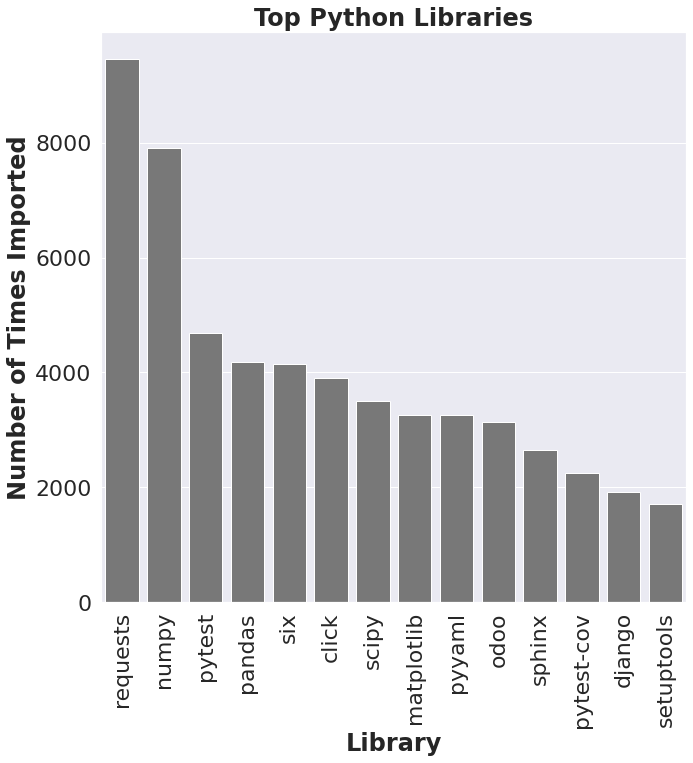

In [17]:
#Plot bar graph of head of dependency
print('Building graph...')

sns.set(style="darkgrid",rc={'figure.figsize':(10,10)}, font_scale = 2 )
plt.title('Top Python Libraries', fontweight = 'bold')
sns.set_palette('deep')
#plt.figure(figsize= )

plt.xticks(rotation=90)
plt.xlabel('Library', fontweight='bold')
plt.ylabel('Number of Times Imported', fontweight='bold')
plt.tight_layout()
x_plot = list(h_sorted_dict.keys())[-14:]
y_plot = list(h_sorted_dict.values())[-14:]
x_plot.reverse()
y_plot.reverse()
sns.barplot(x=x_plot, y=y_plot, color = "#787878" )


plt.savefig('most_dep_graph.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [18]:
#Save file of dependencies dictionary

out_file = open("deps_dictionary.json", "w") 
json.dump(reliance, out_file) 
out_file.close()

<a id = "section2"></a>
## Section 2: Statistical Analysis of Dependencies

In [19]:
#identify how many dependencies the major libraries have
#Employed in CCDF plot below
majors = [a for a in reliance_list if a[1]>= 1704] #number of dependencies in setuptools
sum_majors = sum([a[1] for a in majors])
sum_majors, (sum_majors/total_deps)*100, (len(majors)/len(reliance_list))*100

#0.07% of libraries comprise 24% of dependencies PLACED ON GRAPH BELOW

(55979, 24.208810123078788, 0.07017192120695705)

Text(0.5, 1.0, 'Distribution of Packages Uses as a Dependency')

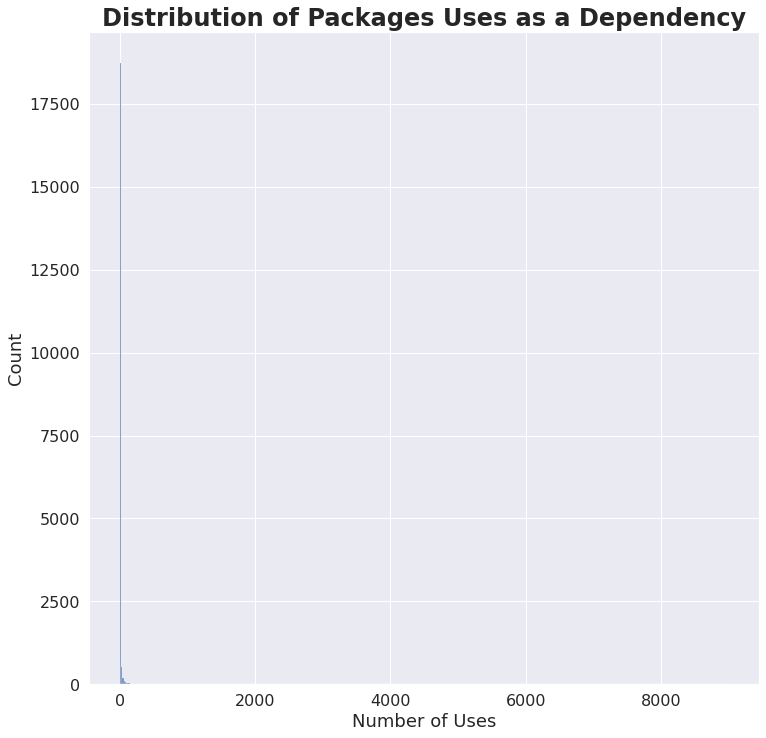

In [20]:
#plot histgoram of all libraries
#Using traditonal binning methods
#convert list to just list of number of dependencies
distro = [a[1] for a in reliance_list]
sns.set(rc={'figure.figsize':(12,12)})
sns.histplot(distro, bins =np.linspace(1,9000,500))
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.ylabel('Count', fontsize=18)
plt.xlabel('Number of Uses', fontsize=18)
plt.title('Distribution of Packages Uses as a Dependency', fontsize = 24, fontweight ='bold')

In [21]:
#Assess type of heavy tailed distribution 

dist_results = {"Distribution 1": [], "Distribution 2":[], "R":[], "p":[]}
best = "" 

results = powerlaw.Fit(distro)
type_heavy = list(results.supported_distributions.keys())
for ty in type_heavy:
    for other in type_heavy: 
        if ty != other: 
            R, p = results.distribution_compare(ty, other)
            dist_results["Distribution 1"].append(ty)
            dist_results["Distribution 2"].append(other)
            dist_results["R"].append(R)
            dist_results['p'].append(p)

count_check = 0
base = "power_law"
#Get best fit
for i in range(len(dist_results["Distribution 1"])):    
    dist = dist_results["Distribution 1"][i]
    if base != dist: 
        base = dist
        count_check = 0
        if dist_results["R"][i] > 0: 
            count_check += 1
    else: 
        if dist_results["R"][i] > 0: 
            count_check += 1
        if count_check == 5: 
            best = dist
            
#Put results in table for reference           
dist_results = pd.DataFrame.from_dict(dist_results)
#see distribution type
best

Calculating best minimal value for power law fit


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


'truncated_power_law'

Text(0.5, 0, 'Number of Imports')

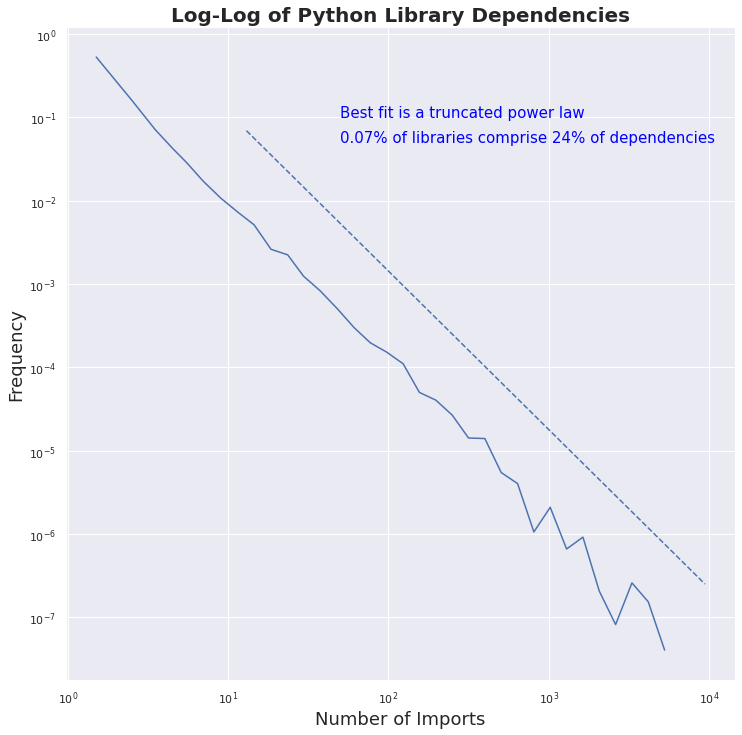

In [22]:
sns.set(rc={'figure.figsize':(12,12)})
plt.title('Log-Log of Python Library Dependencies', fontsize = 20, fontweight ='bold')
powerlaw.plot_pdf(distro, color='b')
results.power_law.plot_pdf(color='b', linestyle='--')
style = dict(size=15, color='blue')
plt.text(50, 0.1, "Best fit is a truncated power law", **style)
plt.text(50, 0.05, "0.07% of libraries comprise 24% of dependencies", **style)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Number of Imports', fontsize=18)

<a id = "section3"></a>
## Section 3: Convert into a Graph and Run Network Statistics
#### Do not rerun these due to time, just open the pickle object in [section 4](#section4)

In [23]:
keys = list(libs_deps.keys())

libs_with_deps = {}

for k,v in libs_deps.items(): 
    if v != None: 
        libs_with_deps[k] = v #removes non_connected nodes

len(libs_with_deps) #number of libraries that do imports

46548

In [24]:
len(keys) - len(libs_with_deps) - no_deps #verify numbers all validated packages - packages with dependencies- packages without dependencies. 

0

In [25]:
#Create graph of all links
from itertools import combinations

G = nx.Graph()
#make a directed graph
DG = nx.DiGraph()

for k,v in libs_with_deps.items():  
    G.add_node(k)
    DG.add_node(k)
    edge_set = set()
    for node in v:
        #Remove version control
        if '==' in node: 
            idx = node.find('==')
            node = node[:idx]
        if (k, node) not in edge_set:
            edge_set.update([(node,k)])
    edge_list = list(edge_set)
    G.add_edges_from(edge_list)
    DG.add_edges_from(edge_list) #Digraph is set up so imports go to using code (e.g. numpy --> <library using nump>)
        
    

In [26]:
len(G) #Total size of graph

59311

In [27]:
nx.density(G)

0.00012374324651097054

In [28]:
with open("Dependency Graphs/deps_graph.pkl", 'wb') as pkl_object:
    pickle.dump(G, pkl_object)

In [29]:
with open("Dependency Graphs/deps_directed_graph.pkl", 'wb') as pkl_object:
    pickle.dump(DG, pkl_object)

In [31]:
with open('Dependency Graphs/deps_graph.pkl', 'rb') as file:
    G = pickle.load(file)

In [ ]:
#Calculate Centrality Score
centrality = nx.betweenness_centrality(G)

In [ ]:
#Save to file
with open("deps_central.pkl", 'wb') as pkl_object:
    pickle.dump(centrality, pkl_object)

In [ ]:
#Calculate eigenvector scores
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

In [ ]:
#Save to file
with open("Dependency Graphs/eigen_central.pkl", 'wb') as pkl_object:
    pickle.dump(eigenvector, pkl_object)

In [42]:
page_rank = nx.pagerank(G)

In [43]:
#Save to file
with open("Dependency Graphs/page_rank.pkl", 'wb') as pkl_object:
    pickle.dump(page_rank, pkl_object)

In [ ]:
#Calculate Degree Centrality
deg_centrality = nx.degree_centrality(G)

In [ ]:
#Calculate Closeness Centrality
closeness = nx.closeness_centrality(G)

In [ ]:
with open("Dependency Graphs/closeness.pkl", 'wb') as pkl_object:
    pickle.dump(closeness, pkl_object)

In [29]:
nx.is_connected(G)

False

In [112]:
comp = list(nx.connected_components(G))

len(comp)

475

In [56]:
#Get Giant Component
comps = list(nx.connected_components(G))
Gc = nx.subgraph(G, comps[0])
len(Gc.nodes)

58097

In [114]:
nx.density(Gc)

0.00012850248115660773

Text(10000, 400, 'Giant consists of 98.0% of the network.')

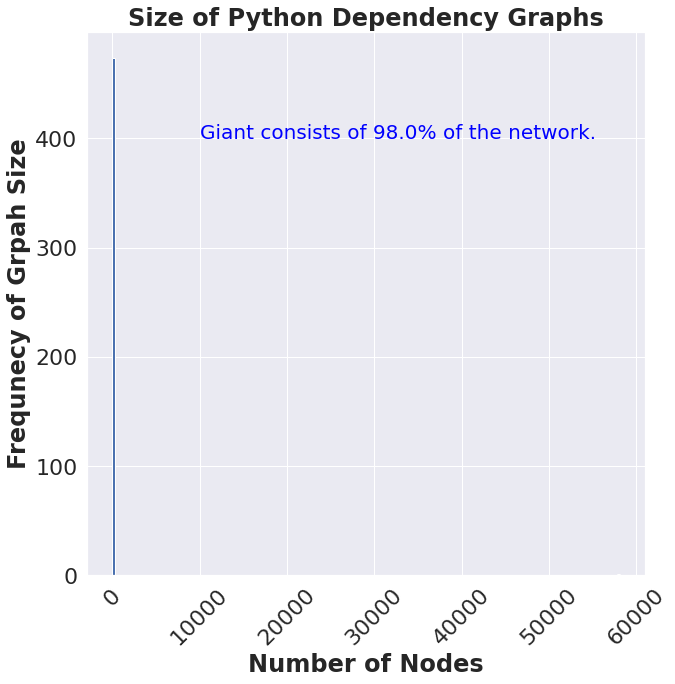

In [45]:
hist_nets = []
for sub in comp:
    hist_nets.append(len(sub))
g = round(max(hist_nets)/sum(hist_nets),2)*100

sns.set(style="darkgrid",rc={'figure.figsize':(10,10)}, font_scale = 2 )
plt.title('Size of Python Dependency Graphs', fontweight = 'bold')
#plt.figure(figsize= )

plt.xticks(rotation=45)
plt.xlabel('Number of Nodes', fontweight='bold')
plt.ylabel('Frequnecy of Grpah Size', fontweight='bold')    
plt.hist(hist_nets, bins = 200)
style = dict(size=20, color='blue')
plt.text(10000, 400, "Giant consists of {}% of the network.".format(g), **style)

In [60]:
DAC = nx.degree_assortativity_coefficient(G)
DAC #-0.15169

-0.15169004790057586

In [59]:
#For Giant component
Gc_DAC = nx.degree_assortativity_coefficient(Gc)
Gc_DAC  #-0.15233

-0.15233772032282378

In [61]:
DPC = nx.degree_pearson_correlation_coefficient(G)
DPC #-0.15169

-0.151690047900576

In [62]:
#For Giant component
DPC = nx.degree_pearson_correlation_coefficient(Gc)
DPC  -0.152338

-0.15233772032282367

In [33]:
avg_degree = nx.average_neighbor_degree(G)
len(avg_degree)

59311

In [40]:
degrees = [val for (node, val) in G.degree() if val !=0]
len(degrees)

59305

In [53]:
des2 = sorted(list(G.degree()), key=lambda data: data[1], reverse=True)
des2[0:15]

[('requests', 9342),
 ('numpy', 7755),
 ('six', 4112),
 ('pandas', 4096),
 ('pytest', 3913),
 ('click', 3848),
 ('scipy', 3440),
 ('pyyaml', 3184),
 ('odoo', 3135),
 ('matplotlib', 3088),
 ('sphinx', 2082),
 ('django', 1888),
 ('pytest-cov', 1777),
 ('setuptools', 1674),
 ('python-dateutil', 1614)]

In [41]:
dist_results = {"Distribution 1": [], "Distribution 2":[], "R":[], "p":[]}
best = "" 

results = powerlaw.Fit(degrees)
type_heavy = list(results.supported_distributions.keys())
for ty in type_heavy:
    for other in type_heavy: 
        if ty != other: 
            R, p = results.distribution_compare(ty, other)
            dist_results["Distribution 1"].append(ty)
            dist_results["Distribution 2"].append(other)
            dist_results["R"].append(R)
            dist_results['p'].append(p)

count_check = 0
base = "power_law"
#Get best fit
for i in range(len(dist_results["Distribution 1"])):    
    dist = dist_results["Distribution 1"][i]
    if base != dist: 
        base = dist
        count_check = 0
        if dist_results["R"][i] > 0: 
            count_check += 1
    else: 
        if dist_results["R"][i] > 0: 
            count_check += 1
        if count_check == 5: 
            best = dist
            
#Put results in table for reference           
dist_results = pd.DataFrame.from_dict(dist_results)
#see distribution type
best

Calculating best minimal value for power law fit


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


'power_law'

Text(0.5, 0, 'Number of Degrees')

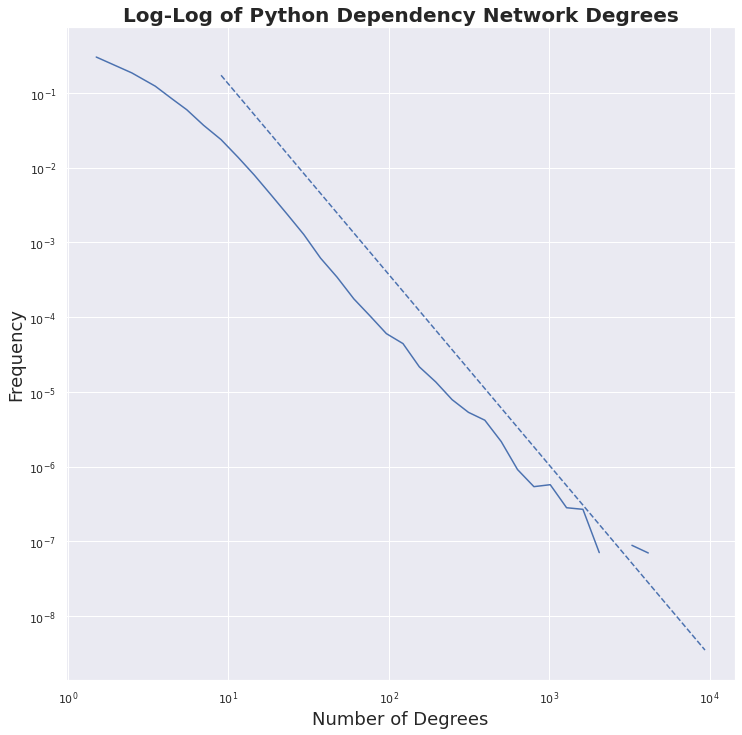

In [47]:
sns.set(rc={'figure.figsize':(12,12)})
plt.title('Log-Log of Python Dependency Network Degrees', fontsize = 20, fontweight ='bold')
powerlaw.plot_pdf(degrees, color='b')
results.power_law.plot_pdf(color='b', linestyle='--')
style = dict(size=15, color='blue')
#plt.text(50, 0.1, "Best fit is a truncated power law", **style)
#plt.text(50, 0.05, "0.07% of libraries comprise 24% of dependencies", **style)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Number of Degrees', fontsize=18)

In [64]:
#For Giant component
avg_degree = nx.average_neighbor_degree(Gc)
avg_degree

{'0-core': 523.0,
 'redis': 15.632887189292543,
 'grid': 662.6,
 'etcd3': 17.571428571428573,
 'aioredis': 13.28048780487805,
 'jinja2': 15.92794017675051,
 'netaddr': 23.66906474820144,
 'python-dateutil': 19.892193308550187,
 'contract_addresses': 850.7692307692307,
 'black': 28.117863720073665,
 'mypy': 23.77358490566038,
 'bandit': 32.38157894736842,
 'pylint': 17.456603773584906,
 'mypy-extensions': 25.80701754385965,
 'pytest': 17.418093534372606,
 'twine': 33.00693641618497,
 'pycodestyle': 29.252475247524753,
 'coverage': 20.61596958174905,
 'coveralls': 18.287958115183248,
 'tox': 39.28270042194093,
 'pydocstyle': 21.13235294117647,
 'sphinx': 30.59462055715658,
 'contract_artifacts': 850.7692307692307,
 'contract_wrappers': 572.3809523809524,
 '0x-json-schemas': 22.0,
 'eth-utils': 23.31578947368421,
 'web3': 17.08695652173913,
 '0x-order-utils': 20.666666666666668,
 'sphinx-autodoc-typehints': 59.666666666666664,
 'attrs': 36.8160237388724,
 '0x-contract-addresses': 20.6,
 '

In [55]:
degree_dict = {}
for k,v in list(G.degree()):
    degree_dict[k] = v

In [56]:
history2 = []
degree_head = sep_bins(degree_dict, history2)

Ratio Head to tail: 0.21114537175062792 and Ratio Weight: 0.41218912412974223
Ratio Head to tail: 0.15196078431372548 and Ratio Weight: 0.6178559244193675
Ratio Head to tail: 0.18300086730268864 and Ratio Weight: 0.4874191004832502
Ratio Head to tail: 0.2485207100591716 and Ratio Weight: 0.5578487771061625
Ratio Head to tail: 0.3548387096774194 and Ratio Weight: 0.7131576205854776
Ratio Head to tail: 0.2222222222222222 and Ratio Weight: 1.807217640521729
Ratio Head to tail: 1.0 and Ratio Weight: 0.8301220295439948


In [61]:
degree_head[-3]

({'pytest': 3913,
  'sphinx': 2082,
  'six': 4112,
  'requests': 9342,
  'click': 3848,
  'matplotlib': 3088,
  'numpy': 7755,
  'scipy': 3440,
  'pyyaml': 3184,
  'pandas': 4096,
  'odoo': 3135},
 {'jinja2': 1471,
  'python-dateutil': 1614,
  'twine': 865,
  'tox': 711,
  'coverage': 1315,
  'attrs': 674,
  'certifi': 609,
  'urllib3': 916,
  'mock': 833,
  'tqdm': 1527,
  'sphinx-rtd-theme': 914,
  'flake8': 1288,
  'wheel': 877,
  'aiohttp': 910,
  'beautifulsoup4': 1054,
  'pillow': 1439,
  'scikit-learn': 1237,
  'pytest;': 765,
  'flask': 1384,
  'future': 1067,
  'pytest-cov': 1777,
  'sqlalchemy': 1002,
  'boto3': 1105,
  'lxml': 1369,
  'setuptools': 1674,
  'cryptography': 675,
  'django': 1888,
  'colorama': 882,
  'pytz': 1074,
  'networkx': 634,
  'psutil': 678})

In [65]:
avg_deg_connectivity = nx.average_degree_connectivity(G)
len(avg_deg_connectivity)

312

In [66]:
#For Giant component
avg_deg_connectivity = nx.average_degree_connectivity(Gc)
len(avg_deg_connectivity)

311

In [ ]:
local = nx.local_efficiency(G)
local # 0.1359

In [58]:
#For Giant component
local = nx.local_efficiency(Gc)
local # 0.13759

0.13759161812911658

In [67]:
global_eff = nx.global_efficiency(G)
global_eff # 0.25675

0.2567513806557808

In [68]:
#For Giant component
global_eff = nx.global_efficiency(Gc)
global_eff # 0.26759

0.2675928242173686

## Resilience Calculation

### This apporach did not seem to produce any meanfigul results in both the directed and undirected form

See Gao, et al.  "Universal Resilience patterns in complex networks." Nature, Vol. 530, pp 307-312, 18 Feb 2016.

Note: '{}' are used to denote average, in this context.

beta_eff = {s} + SH

bete_eff -> effective resilience for the syetem.

{s} -> average network density = average weighted degree.

S -> network symmetry = ({Sin*Sout} - {Sin}{Sout}) = 1 for undirected graph.

H -> sigma^2/{s}

sigma^2 -> variance of the probability density function, P(s).

The larger the beta_eff value, the more resilient the network.  Note: We may want to consider comparing this value to that of a similar network of "known" stability so we have some sort of reference point.


In [70]:
#Instantiate graph
with open('Dependency Graphs/deps_graph.pkl', 'rb') as file:
    G = pickle.load(file)

In [71]:
#Get degree vector of G
degrees = list(G.degree)
degree_vector = []
for d in degrees:
    degree_vector.append(d[1])
    
degree_vector = [float(d) for d in degree_vector]

print(degree_vector[0:10])

[1.0, 523.0, 5.0, 7.0, 82.0, 1471.0, 139.0, 1614.0, 13.0, 543.0]


In [72]:
#Directed Graph
#Get degree vector of G
degrees = list(DG.degree)
in_degree = list(DG.in_degree)
out_degree = list(DG.out_degree)

degree_vector = []
out_vector = []
in_vector = []
for idx in range(len(degrees)):
    degree_vector.append(degrees[idx][1])
    in_vector.append(in_degree[idx][1])
    out_vector.append(out_degree[idx][1])
    
def floatize(deg_vec):
    deg_vec = np.array([float(d) for d in deg_vec])
    return deg_vec

degree_array = floatize(degree_vector)
in_array = floatize(in_vector)
out_array = floatize(out_vector)

print(degree_array[0:10])
print(out_array[0:10])
print(in_array[0:10])

[1.000e+00 5.240e+02 5.000e+00 7.000e+00 8.200e+01 1.471e+03 1.390e+02
 1.614e+03 1.300e+01 5.430e+02]
[   0.  522.    0.    7.   80. 1469.  139. 1613.    0.  534.]
[ 1.  2.  5.  0.  2.  2.  0.  1. 13.  9.]


In [73]:
#Undirected Graph
#Calculate variance, {S}, H, and beta_eff

#degree_array = np.array(degree_vector)
v = np.var(degree_array)
s = np.mean(degree_array)
d = nx.density(G)
H = s/v

beta_eff = d + 1.0*H

print ("Density: ", d)
print("Average Weighted Degree: ", s)
print("Variance (for H calc): ",v)
print("H: ", H)
print("beta_eff: ", beta_eff)


Density:  0.00012374324651097054
Average Weighted Degree:  7.344404916457318
Variance (for H calc):  5341.362071804075
H:  0.0013750060036609173
beta_eff:  0.0014987492501718877


In [74]:
#Directed Grpah
#Calculate variance, {S}, H, and beta_eff

#degree_array = np.array(degree_vector)
v = np.var(degree_array)
v1 = np.var(in_array)
v2 = np.var(out_array)
s = np.mean(degree_array)
s1 = np.mean(in_array)
s2 = np.mean(out_array)

density = nx.density(DG)
heterogeneity = v/density
symmetry = (s - (s1*s2))/v

#H = s/v

beta_eff = density + symmetry*heterogeneity

#print("Average Weighted Degree: \n all: {}\n in: {} \n out: {}".format(s, s1, s2))
#print("Variance (for H calc):  \n all: {}\n in: {} \n out: {}".format(v, v1, v2))
print ("Density: ", density)
print("Symmetry: ", symmetry)
print("H: ", heterogeneity)
print("beta_eff: ", beta_eff)


Density:  6.191540142014263e-05
Symmetry:  -0.001149644209700475
H:  86268714.23410325
beta_eff:  -99178.32773562636


## Small Worldedness

### Due ot the size of the network this calculation appears intractable. We also attempted networkx function for similar purpose. 

See Humphries, et al. "Network 'Small-Word-Ness': A Quantitiative Method for Determining Canonical Network Equivalence." PLoS One, Vol. 3(4), April 2008.

sigma = Small Coefficient = (C/Cr)/(L/Lr)

C -> Clustering coefficient of graph (based on transitivity measure, (3*# of triangles) / (# of triads))

Cr -> Clustering coefficient of random, equivalent graph

L -> Average shortest path of graph

Lr -> Average shortest path of random, equivalent graph

sigma > 1 indicates "Small World Network"

In [75]:
#Build Gsub

#Get largest fully connected community in G
largest_cc = max(nx.connected_components(G), key=len)
Gsub = G.subgraph(largest_cc).copy()
rel_size = float(len(Gsub.nodes))/float(len(G.nodes))
print("Gsub as fraction of G: ",rel_size)

Gsub as fraction of G:  0.9795316214530189


In [76]:
#Calculate G parameters for largest fully connected subgraph

C = nx.transitivity(Gsub)
L = nx.average_shortest_path_length(Gsub)

print("Transitivity: ",C)
print("Average Shortest Path Length: ", L)

Transitivity:  0.0019847790293555877
Average Shortest Path Length:  4.044182567452991


In [77]:
#Calculate sigma from random graph approximations
import math

#C = 0.001985243263767216
#L = 4.047592300108424

n = len(Gsub.nodes)

Lr_a = math.log(float(n))/math.log(s)

Cr_a = s/float(n)

sigma_a = (C/Cr_a)*(Lr_a/L)
print("Approximate Small Coefficient: ", sigma_a)

Approximate Small Coefficient:  21.35837148867997


In [ ]:
#Generate and save random graph--- Calculation porvies intractable for this size network

Gr = nx.random_reference(Gsub)

with open("Dependency Graphs/random_graph.pkl", 'wb') as pkl_object:
    pickle.dump(Gr, pkl_object)

In [ ]:
#Instantiate random graph from file
with open('random_graph.pkl', 'rb') as file:
    Gr = pickle.load(file)

In [ ]:
#Calculate sigma from random graph

Gr = nx.random_reference(Gsub)

Cr = nx.transitivity(Gr)
Lr = nx.average_shortest_path_length(Gr)

sigma = (C/Cr)*(Lr/L)
print("Small Coefficient: ", sigma)

<a id = "section4"></a>
## Section 4: Dependency Network Statistics Outputs

In [115]:
#Open pickle file storing centrality scores
with open("Dependency Graphs/deps_central.pkl",'rb') as pkl_object:
    centrality= pickle.load(pkl_object)
centrality['requests']

0.2655963992879705

In [116]:
#Sort dictionary based on centrality score

b_sorted = sorted(centrality.items(), key=operator.itemgetter(1))
b_sorted_dict = collections.OrderedDict(b_sorted)

Building graph...


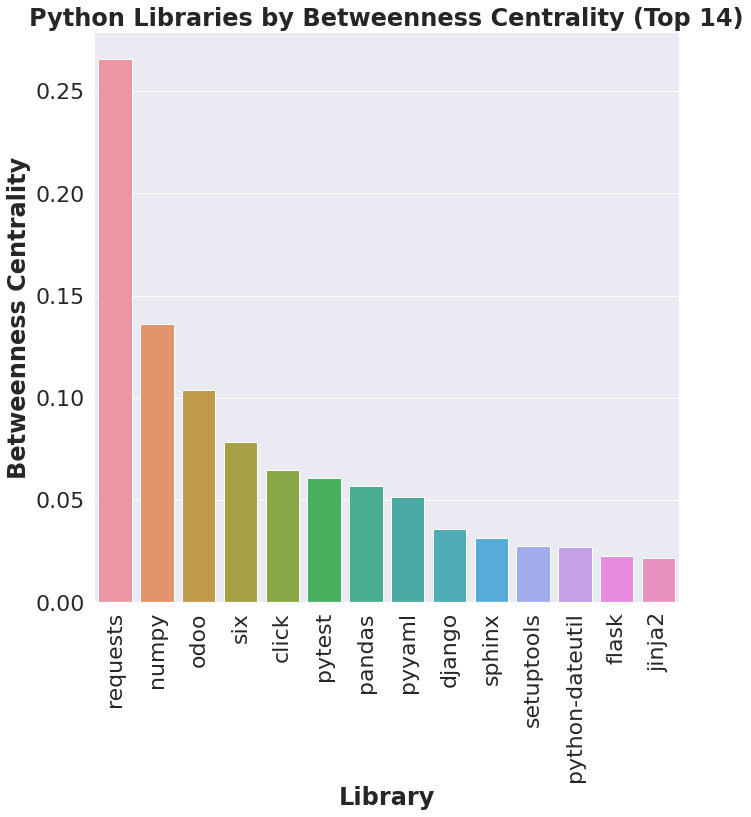

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#b_sorted = sorted(centrality.items(), key=operator.itemgetter(1))
#b_sorted_dict = collections.OrderedDict(b_sorted)
print('Building graph...')

sns.set(style="darkgrid",rc={'figure.figsize':(10,10)}, font_scale = 2 )
plt.title('Python Libraries by Betweenness Centrality (Top 14)', fontweight = 'bold')
#plt.figure(figsize= )

plt.xticks(rotation=90)
plt.xlabel('Library', fontweight='bold')
plt.ylabel('Betweenness Centrality', fontweight='bold')
plt.tight_layout()
x_plot = list(b_sorted_dict.keys())[-14:]
y_plot = list(b_sorted_dict.values())[-14:]
x_plot.reverse()
y_plot.reverse()
sns.barplot(x=x_plot, y=y_plot)


plt.savefig('centralities_graph.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [118]:
#Open pickle file storing eigen centrality scores
with open("Dependency Graphs/eigen_central.pkl",'rb') as pkl_object:
    eigenvector= pickle.load(pkl_object)
eigenvector['numpy']

0.38049270351401165

In [119]:
#Sort dictionary based on eigenvector score
e_sorted = sorted(eigenvector.items(), key=operator.itemgetter(1))
e_sorted_dict = collections.OrderedDict(e_sorted)

Building graph...


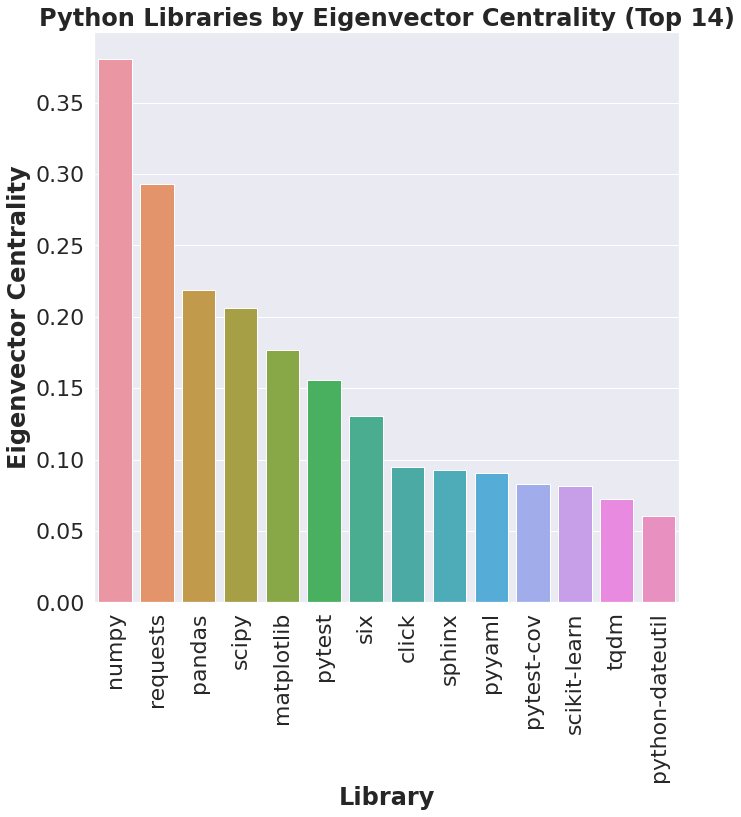

In [120]:
#b_sorted = sorted(centrality.items(), key=operator.itemgetter(1))
#b_sorted_dict = collections.OrderedDict(b_sorted)
print('Building graph...')

sns.set(style="darkgrid",rc={'figure.figsize':(10,10)}, font_scale = 2 )
plt.title('Python Libraries by Eigenvector Centrality (Top 14)', fontweight = 'bold')
#plt.figure(figsize= )

plt.xticks(rotation=90)
plt.xlabel('Library', fontweight='bold')
plt.ylabel('Eigenvector Centrality', fontweight='bold')
plt.tight_layout()
x_plot = list(e_sorted_dict.keys())[-14:]
y_plot = list(e_sorted_dict.values())[-14:]
x_plot.reverse()
y_plot.reverse()
sns.barplot(x=x_plot, y=y_plot)


plt.savefig('centralities_graph.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [121]:
with open("Dependency Graphs/page_rank.pkl",'rb') as pkl_object:
    page_rank= pickle.load(pkl_object)
page_rank['requests']

0.02305431516355502

In [122]:
#Sort dictionary based on eigenvector score
p_sorted = sorted(page_rank.items(), key=operator.itemgetter(1))
p_sorted_dict = collections.OrderedDict(p_sorted)

In [123]:
#Sort dictionary based on page rank score

p_sorted = sorted(page_rank.items(), key=operator.itemgetter(1))
p_sorted_dict = collections.OrderedDict(p_sorted)

Building graph...


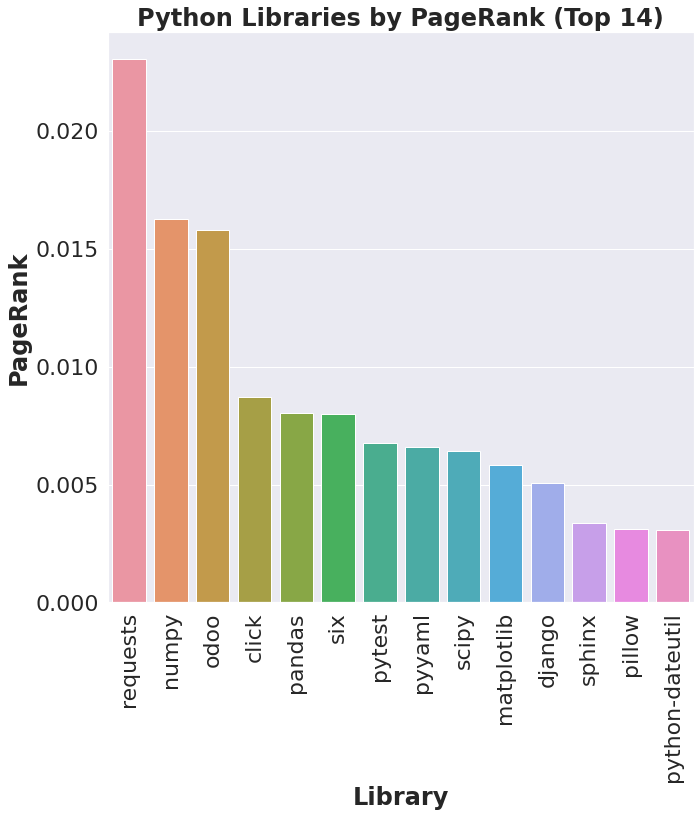

In [124]:
#b_sorted = sorted(centrality.items(), key=operator.itemgetter(1))
#b_sorted_dict = collections.OrderedDict(b_sorted)
print('Building graph...')

sns.set(style="darkgrid",rc={'figure.figsize':(10,10)}, font_scale = 2 )
plt.title('Python Libraries by PageRank (Top 14)', fontweight = 'bold')
#plt.figure(figsize= )

plt.xticks(rotation=90)
plt.xlabel('Library', fontweight='bold')
plt.ylabel('PageRank', fontweight='bold')
plt.tight_layout()
x_plot = list(p_sorted_dict.keys())[-14:]
y_plot = list(p_sorted_dict.values())[-14:]
x_plot.reverse()
y_plot.reverse()
sns.barplot(x=x_plot, y=y_plot)


plt.savefig('pagerank_graph.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [125]:
#Sort dictionary based on closeness rank score
cl_sorted = sorted(page_rank.items(), key=operator.itemgetter(1))
cl_sorted_dict = collections.OrderedDict(p_sorted)

Building graph...


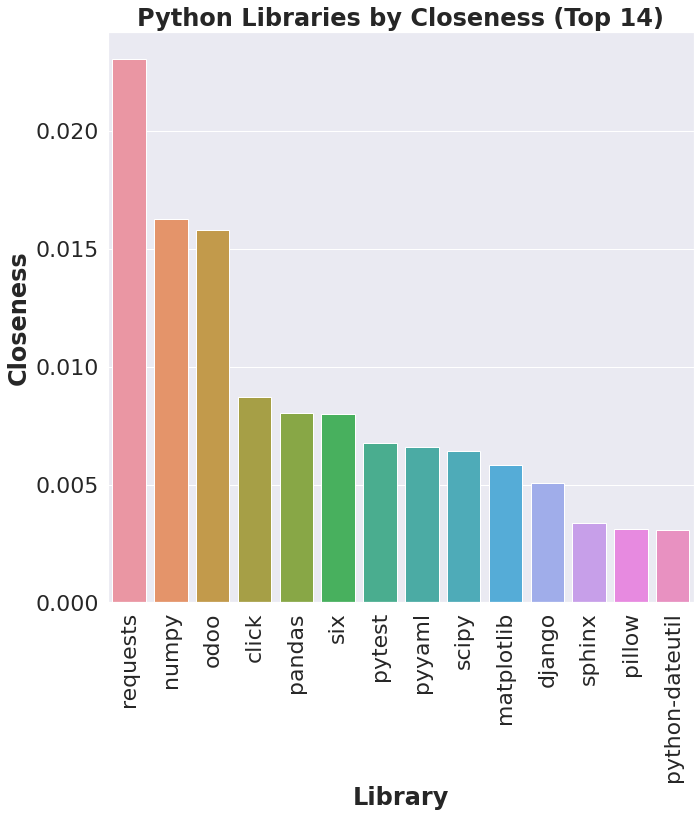

In [126]:
print('Building graph...')

sns.set(style="darkgrid",rc={'figure.figsize':(10,10)}, font_scale = 2 )
plt.title('Python Libraries by Closeness (Top 14)', fontweight = 'bold')
#plt.figure(figsize= )

plt.xticks(rotation=90)
plt.xlabel('Library', fontweight='bold')
plt.ylabel('Closeness', fontweight='bold')
plt.tight_layout()
x_plot = list(p_sorted_dict.keys())[-14:]
y_plot = list(p_sorted_dict.values())[-14:]
x_plot.reverse()
y_plot.reverse()
sns.barplot(x=x_plot, y=y_plot)


plt.savefig('closeness_graph.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [127]:
#reverse lists to go from greatest ot least
b_sorted.reverse()
e_sorted.reverse()

(-0.01, 0.39049270351401166)

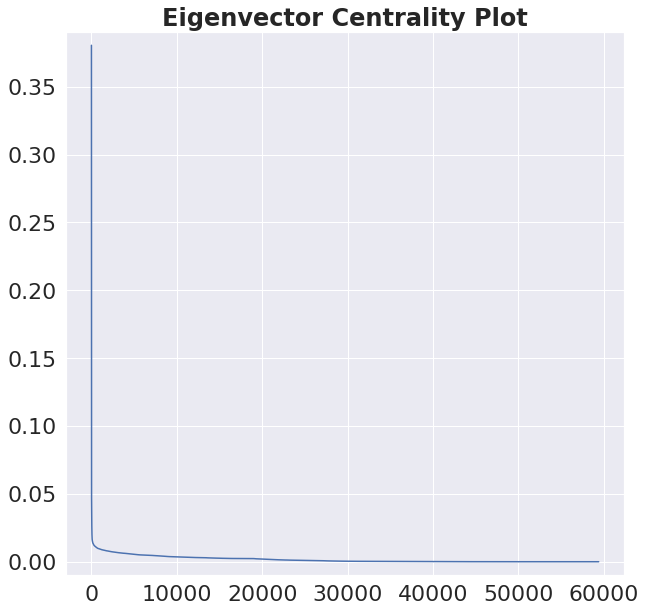

In [128]:
x = []
y = []
for i in range(len(e_sorted)):
    x.append(i)
    y.append(e_sorted[i][1])
    
plt.title('Eigenvector Centrality Plot', fontweight = 'bold')
plt.plot(x,y)
plt.ylim([-0.01,y[0]+.01])

#Next step in research leverage the elbow method to explore network dynamics eigenvector centrality (bends at ~100)

(-0.01, 0.27559639928797053)

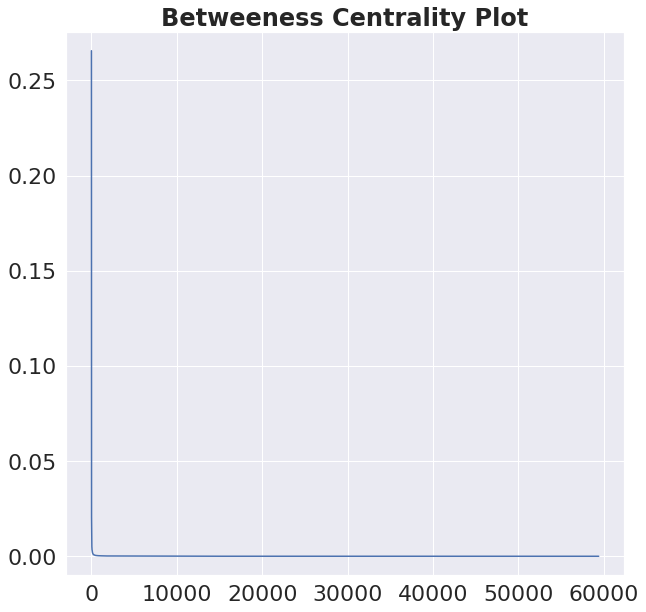

In [129]:
x_b = []
y_b = []
for i in range(len(b_sorted)):
    x_b.append(i)
    y_b.append(b_sorted[i][1])
    
plt.title('Betweeness Centrality Plot', fontweight = 'bold')
plt.plot(x_b,y_b)
plt.ylim([-0.01,y_b[0]+.01])

#Next step in research leverage the elbow method to explore network dynamics betweeness centrality (bends at ~100)

## Section 5 Dependency Network as a HyperGraph

In [22]:
import hypernetx as hnx
import hypernetx.algorithms as hmod

In [23]:
hyper_libs = {} #make disjoint

for k,v in libs_with_deps.items(): 
    hyper_libs[k + "_main"] = v
    

In [24]:
hyperdeps = hnx.Hypergraph(hyper_libs) #Too large crashes the kernel


In [25]:
len(hyperdeps)

19951

In [ ]:
s_central = hmod.s_centrality_measures.s_betweenness_centrality(hyperdeps)
s_central

/opt/tljh/user/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
hnx.draw(hyperdeps.collapse_nodes(), with_edge_labels = False, with_node_labels = False)

In [ ]:
def find_mesa(data):
    for i in range(len(data)):
        if data[i][0] == 'mesa':
            print(data[i], i)
            
find_mesa(e_sorted)
find_mesa(b_sorted) #Total length is both lists is 59404

In [1]:
2**78

302231454903657293676544